In [21]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from torch.nn.utils.rnn import pad_sequence
from torch import nn, Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")

In [13]:
print(device)

cuda


# Transformer

In [22]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)
        
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim * 4,  # Assuming 4 times expansion
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        
        # Reshape input to match transformer input shape
        x = x.permute(1, 0, 2)  # Shape: (seq_len, batch_size, hidden_dim)
        
        # Pass through transformer
        x = self.transformer(x, x)
        
        # Reshape output to match FC layer input shape
        x = x.permute(1, 0, 2)  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Apply fully-connected layer
        x = self.fc(x)
        
        # Apply activation function
        x = torch.sigmoid(x)
        
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

# Dataset

In [23]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = np.pad(inp, ((11, 0), (0, 0)))
        return torch.from_numpy(inp).float(), torch.from_numpy(out[:,:2]).float()

# Hyperparameter

In [24]:
input_dim = 4
output_dim = 2
hidden_dim = 128
num_layers = 4
num_heads = 8
dropout = 0.1

batch_size = 64
seq_len = 19

learning_rate = 0.01
decay_rate = 0.95
num_epoch = 100

# Data Loader

In [25]:
train_path = "../train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

# Model, Loss Function and Optimizer

In [26]:
# RNN, LSTM, 1dCNN, Transformer
model = TransformerModel(input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout).to(device) # move model to gpu 

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

# Training

In [27]:
def train_epoch(train_loader, model, optimizer, loss_function):
    train_mse = []
    for inp, tgt in tqdm(train_loader):
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        pred = model(inp)
        loss = loss_function(pred, tgt)
        train_mse.append(loss.item()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    valid_mse = []
    preds = []
    trues = []
    with torch.no_grad():
        for inp, tgt in valid_loader:
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            pred = model(inp)
            loss = loss_function(pred, tgt)
            preds.append(pred.cpu().data.numpy())
            trues.append(tgt.cpu().data.numpy())
            valid_mse.append(loss.item())
            
        preds = np.concatenate(preds, axis = 0)  
        trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse, preds, trues


In [158]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

  5%|▌         | 152/2813 [00:20<05:52,  7.54it/s]


 11%|█         | 303/2813 [00:39<05:01,  8.32it/s]


 16%|█▌        | 454/2813 [00:59<05:14,  7.49it/s]


 22%|██▏       | 605/2813 [01:19<04:58,  7.39it/s]


 27%|██▋       | 756/2813 [01:39<04:24,  7.79it/s]


 32%|███▏      | 907/2813 [01:59<04:10,  7.62it/s]


 38%|███▊      | 1057/2813 [02:19<04:07,  7.09it/s]


 43%|████▎     | 1205/2813 [02:40<04:04,  6.57it/s]


 48%|████▊     | 1353/2813 [03:02<03:31,  6.92it/s]


 53%|█████▎    | 1501/2813 [03:25<03:06,  7.02it/s]


 59%|█████▊    | 1649/2813 [03:47<03:03,  6.34it/s]


 64%|██████▍   | 1797/2813 [04:08<02:15,  7.48it/s]


 69%|██████▉   | 1945/2813 [04:29<01:54,  7.58it/s]


 74%|███████▍  | 2093/2813 [04:50<02:02,  5.89it/s]


 80%|███████▉  | 2241/2813 [05:12<01:19,  7.17it/s]


 85%|████████▍ | 2389/2813 [05:33<00:55,  7.61it/s]


 90%|█████████ | 2537/2813 [05:55<00:38,  7.24it/s]


 95%|█████████▌| 2685/2813 [06:15<00:16,  7.56it/s]


100%|██████████| 2813/2813 [06:34<00:00,  7.13it/s]


Epoch 1 | T: 7.26 | Train RMSE: 0.04669 | Valid RMSE: 0.04580


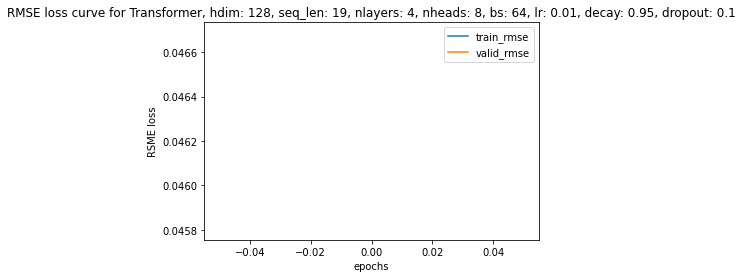

  5%|▌         | 151/2813 [00:22<06:48,  6.52it/s]


 11%|█         | 302/2813 [00:43<05:26,  7.70it/s]


 16%|█▌        | 453/2813 [01:04<05:28,  7.19it/s]


 21%|██▏       | 604/2813 [01:25<05:38,  6.53it/s]


 26%|██▌       | 721/2813 [01:42<04:27,  7.83it/s]

In [ ]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    # model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))

    # model.eval()
    val_rmse, val_preds, val_trues = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))
    
    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for Transformer, hdim: {hidden_dim}, seq_len: {seq_len}, nlayers: {num_layers}, nheads: {num_heads}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}, dropout: {dropout}')
    plt.legend()
    plt.savefig(f'transformer_loss_curve_v1_hdim_{hidden_dim}_seqlen_{seq_len}_nheads_{num_heads}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_dropout_{dropout}.png')
    plt.show()
    
torch.save(best_model.state_dict(), f'transformer_hdim_{hidden_dim}_seqlen_{seq_len}_nheads_{num_heads}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_dropout_{dropout}.pt')

# Evaluation and Submission

In [ ]:
test_path = "./val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(preds)

# Generate Submission File

In [17]:
# # Submission Files
# sample_sub = pd.read_csv('sample_submission.csv')

In [18]:
# Convert to int
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)

NameError: name 'sample_sub' is not defined